# 의료합성데이터 생성 방법 및 합성데이터 개발
## 합성의료데이터 생성 및 평가



*   본 예제는 **"의료빅데이터 큐레이션: 전문인력 양성교육과정"**에서 비정형 합성데이터 실습을 위하여 제작되었습니다.

*   Dataset : [MedMNIST](https://medmnist.com/)

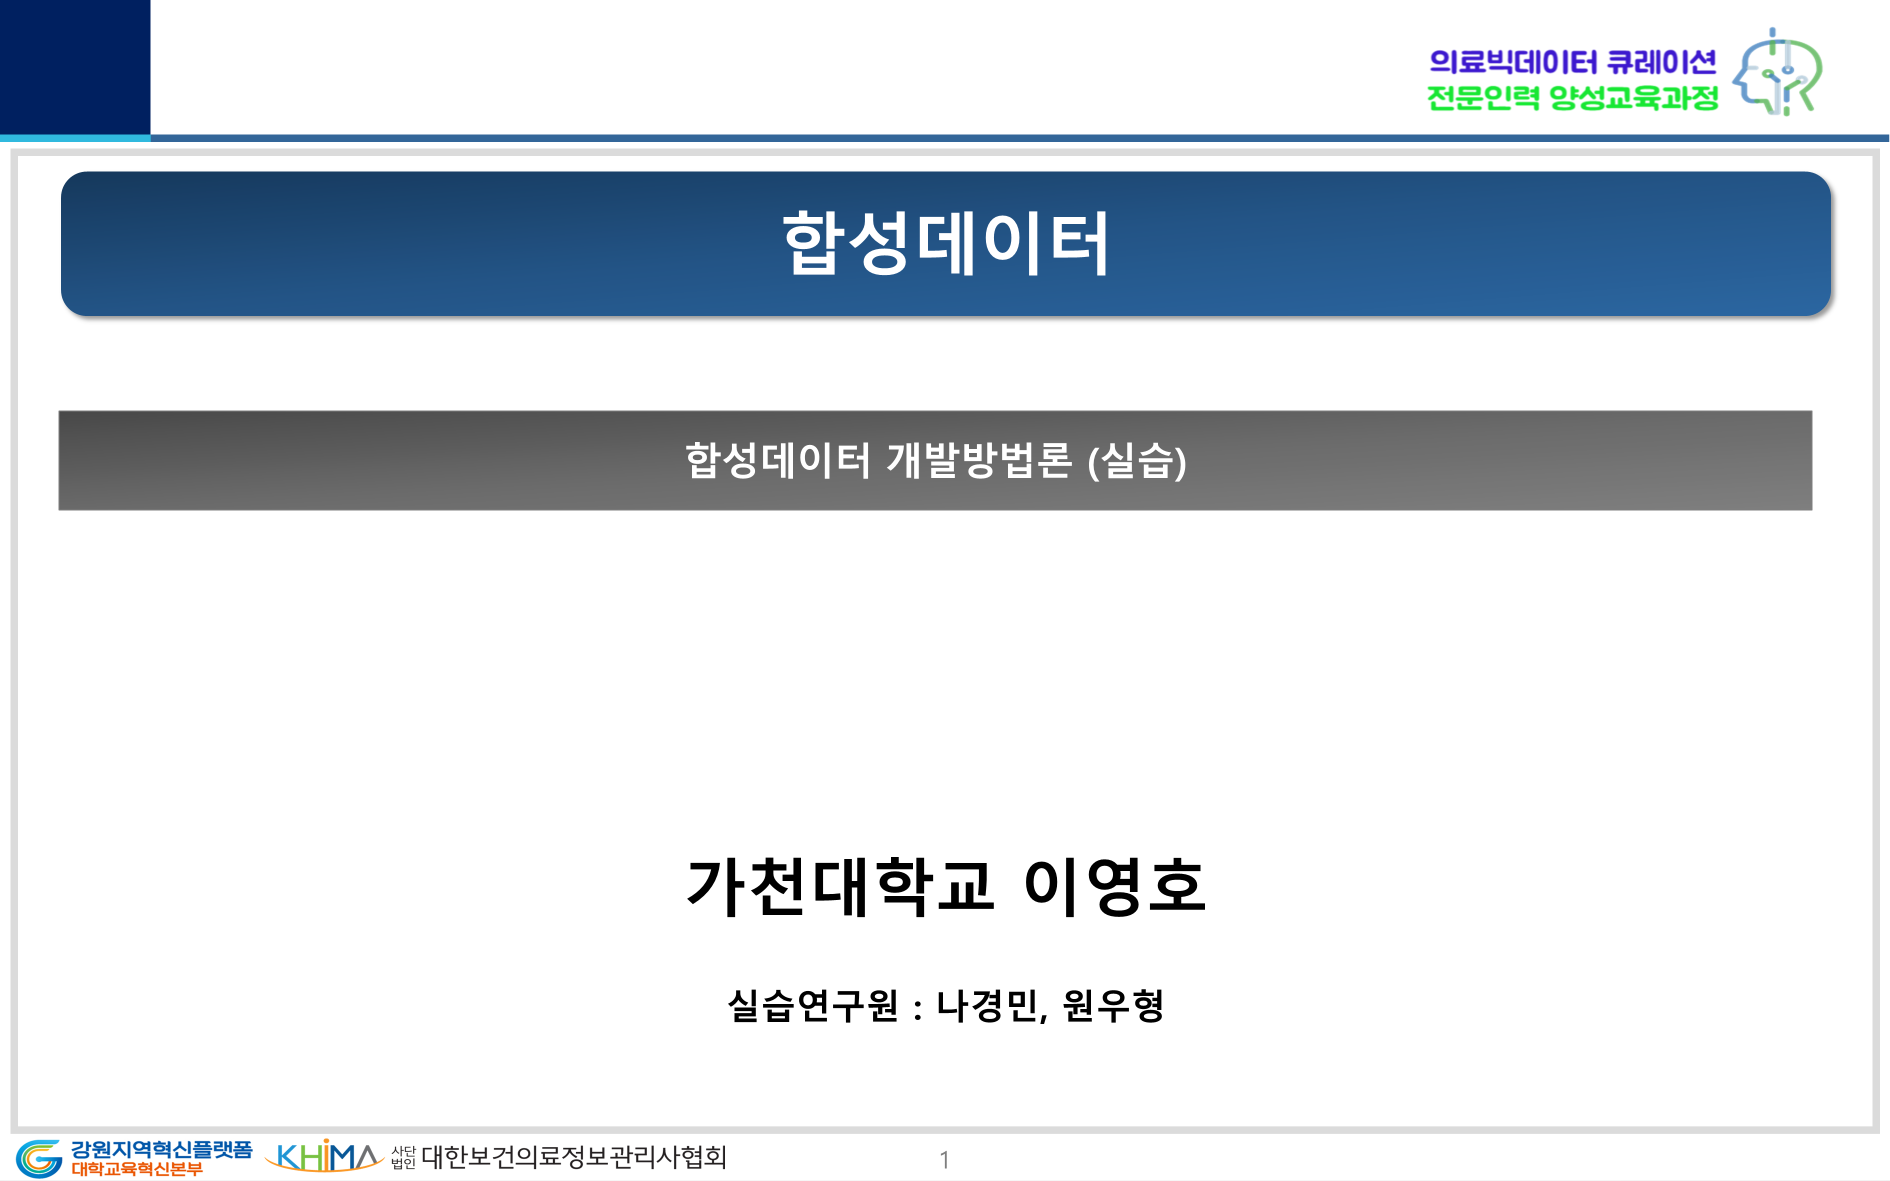

## 라이브러리 및 MedMNIST 선언


In [ ]:
# MedMNIST 패키지 설치
!pip install --upgrade git+https://github.com/MedMNIST/MedMNIST.git

import torch
import torchvision
import matplotlib.pyplot as plt

from torchvision import transforms
from torch.utils.data import DataLoader
from medmnist import PathMNIST, ChestMNIST  # MedMNIST에서 PathMNIST, ChestMNIST 데이터셋 불러오기

  Cloning https://github.com/MedMNIST/MedMNIST.git to /tmp/pip-req-build-borem0wx
  Running command git clone --filter=blob:none --quiet https://github.com/MedMNIST/MedMNIST.git /tmp/pip-req-build-borem0wx
  Resolved https://github.com/MedMNIST/MedMNIST.git to commit 8cce68f261f993bd0450edc0200498a0691362c2
  Preparing metadata (setup.py) ... done


## 데이터 전처리

- 이 예제는 MedMNIST의 pathmnist 데이터셋을 사용하여 진행합니다.
- 이미지 데이터는 1채널(흑백)로 실습을 진행합니다.

In [ ]:
# 사용할 데이터셋 선택 (예: PathMNIST 또는 ChestMNIST)
# 여기서는 PathMNIST를 사용하지만, ChestMNIST 등 다른 MedMNIST 데이터셋으로 교체할 수 있습니다.
data_flag = 'pathmnist'  # 선택지: 'pathmnist', 'chestmnist'
batch_size = 64

# 이미지 변환 설정 (1채널로 변환 추가)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # 이미지를 흑백(1채널)으로 변환
    transforms.Resize(28),      # 이미지를 28x28로 크기 조정
    transforms.ToTensor(),      # PyTorch 텐서로 변환
    transforms.Normalize([0.5], [0.5])  # [-1, 1] 범위로 정규화
])

# MedMNIST 데이터셋 로드
train_dataset = PathMNIST(split='train', transform=transform, download=True)
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz


## Model에 들어갈 이미지를 확인

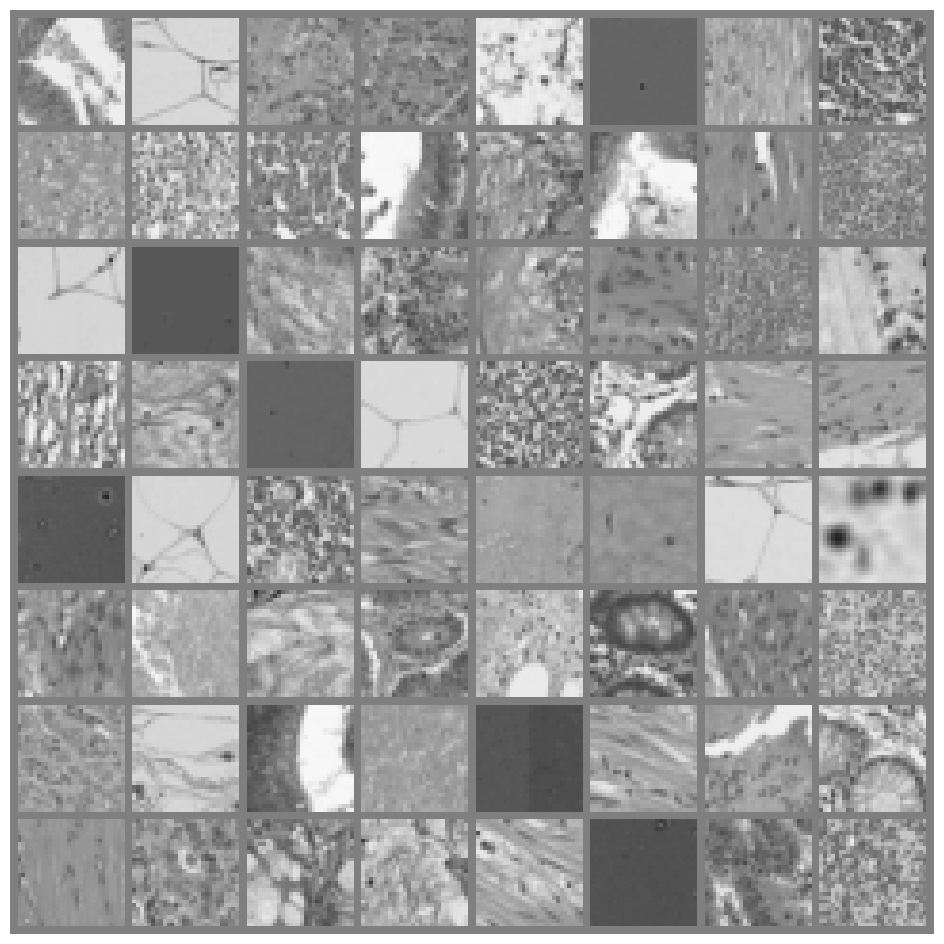

[8, 0, 2, 2, 4, 1, 7, 3, 2, 3, 2, 8, 7, 8, 5, 3, 0, 1, 4, 8, 7, 5, 3, 4, 7, 4, 1, 0, 3, 6, 5, 5, 1, 0, 3, 5, 2, 1, 0, 1, 5, 2, 4, 8, 7, 6, 5, 3, 8, 0, 8, 2, 1, 5, 2, 6, 5, 8, 6, 4, 5, 1, 8, 3]


In [ ]:
# 이미지와 레이블을 배치 단위로 가져오기
images, labels = next(iter(dataloader))

# 이미지 그리드 생성
img_grid = torchvision.utils.make_grid(images, nrow=8, padding=2)
img = img_grid.numpy().transpose(1, 2, 0)  # numpy 형식으로 변환하여 시각화

# 이미지 출력용으로 정규화 해제
std = [0.5]
mean = [0.5]
img = img * std[0] + mean[0]

# 이미지 출력
plt.figure(figsize=(12, 12))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

# 각 이미지에 대한 레이블 출력
print([labels[i].item() for i in range(len(labels))])

- 하나의 batch에 들어있는 Medmnist data를 출력해보았습니다.

## 합성데이터 생성하기
- 아래코드를 실행하면, 비정형 이미지데이터를 생성합니다.

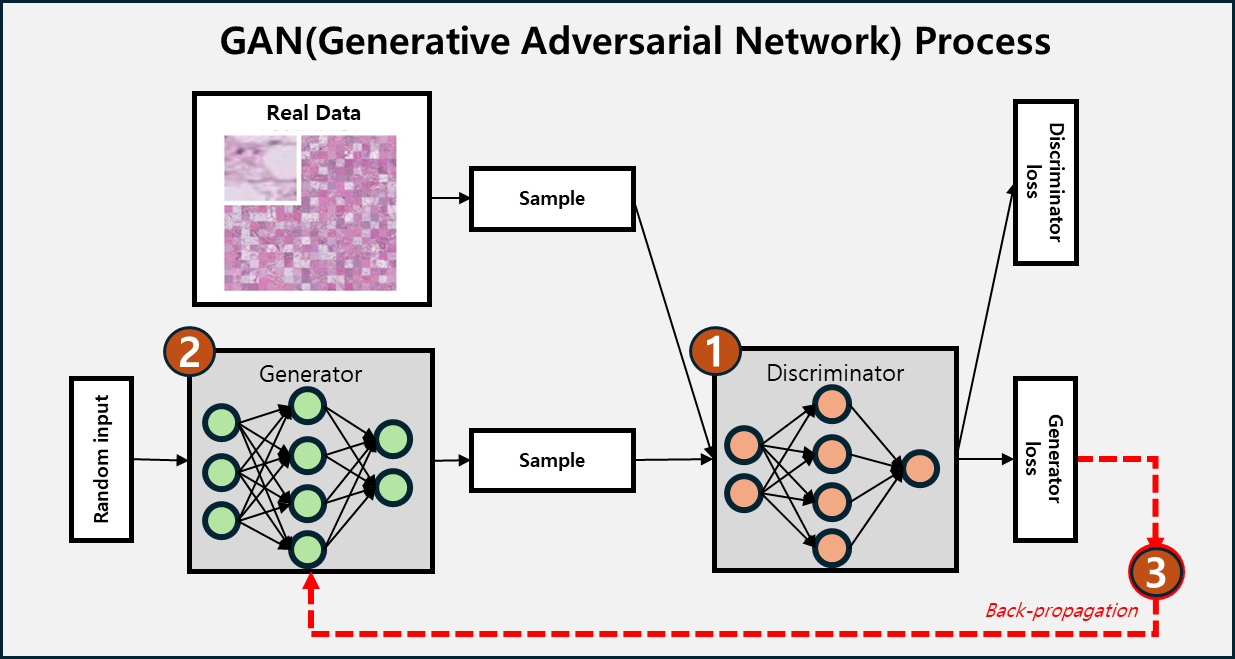

## GAN(Generative Adversarial Network)
* GAN은 접하기 가장 쉬운 생성 모델로, 2014년 Ian J. Goodfellow가 제안한였습니다.
* **GAN의 핵심**은, 두 모델(판별자, 생성자)을 통한 적대적 학습을 통해 **생성자의 진짜같은 가짜 데이터 생성 능력**의 향상입니다.

### 1. Discriminator(판별자)
* 훈련데이터로 학습을 진행하고, 생성자가 생성한 **이미지를 판별**합니다.
* 판별자는 진짜와 가짜 데이터를 구별하도록 학습하며, 이진 분류로 처리됩니다.


### 2. Generator(생성자)
* 무작위 noise vector를 입력받아, **이미지를 생성**합니다.
* 학습 초기에는 품질 낮은 이미지가 생성되나, 판별자의 피드백을 통해 점점 **원본과 유사한 이미지가 생성**됩니다.


### 3. 생성자-판별자간의 상호작용
* **판별자**는 생성된 이미지를 **진짜(1) or 가짜(0)**로 분류합니다. 이 결과는 **생성자**에게 전달됩니다.
* **생성자**는, **판별자**의 잘못된 판단을 통하여 이미지를 개선하는 방향으로 학습합니다.   

In [ ]:
# GAN 모델 실행하기
import torch
import torch.nn as nn
import torch.optim as optim

# 하이퍼파라미터 설정
latent_dim = 100  # 랜덤 노이즈 벡터의 차원
img_size = 28
channels = 1  # 흑백 이미지이므로 1 채널
img_shape = (channels, img_size, img_size)
batch_size = 64
epochs = 10000
lr = 0.0002
beta1 = 0.5

# CUDA 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 생성자(Generator) 모델
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.init_size = img_size // 4
        self.fc = nn.Linear(latent_dim, 128 * self.init_size ** 2)  # 첫 번째 완전 연결 레이어

        # 이미지 생성 과정의 합성곱 블록
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # 이미지 크기를 두 배로 늘림
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh()  # 출력 값을 [-1, 1]로 조정
        )

    def forward(self, z):
        out = self.fc(z)  # 랜덤 노이즈 벡터를 첫 번째 레이어에 입력
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)  # 합성곱 블록을 통해 이미지를 생성
        return img

# 판별자(Discriminator) 모델
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # 이미지 판별을 위한 합성곱 레이어들
        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.25),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten()
        )

        # 임의의 텐서를 통해 출력 크기 계산 (이미지 크기가 28x28일 때)
        with torch.no_grad():
            sample_input = torch.zeros(1, channels, img_size, img_size)
            flattened_dim = self.model(sample_input).shape[1]

        # 마지막 완전 연결 레이어
        self.fc = nn.Sequential(
            nn.Linear(flattened_dim, 1),
            nn.Sigmoid()  # 출력 확률값을 [0, 1]로 조정
        )

    def forward(self, img):
        validity = self.model(img)  # 합성곱 블록을 통해 특징을 추출
        validity = self.fc(validity)  # 완전 연결 레이어를 통해 진짜 여부 판별
        return validity


# 모델 초기화 및 장치로 이동
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# 손실 함수 및 최적화 설정
adversarial_loss = nn.BCELoss()  # 이진 크로스 엔트로피 손실 함수
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# GAN 학습 과정
for epoch in range(epochs):
    # 판별자 학습
    real_imgs, _ = next(iter(dataloader))  # 실제 이미지 가져오기
    real_imgs = real_imgs.to(device)  # 실제 이미지 장치로 이동
    real = torch.ones(real_imgs.size(0), 1, device=device)  # 실제 이미지 레이블 (1)
    fake = torch.zeros(real_imgs.size(0), 1, device=device)  # 가짜 이미지 레이블 (0)

    # 실제 이미지에 대한 손실 계산
    optimizer_D.zero_grad()
    real_loss = adversarial_loss(discriminator(real_imgs), real)

    # 가짜 이미지 생성 및 손실 계산
    z = torch.randn(real_imgs.size(0), latent_dim, device=device)  # 랜덤 노이즈 생성
    fake_imgs = generator(z)  # 생성자 모델을 통해 가짜 이미지 생성
    fake_loss = adversarial_loss(discriminator(fake_imgs.detach()), fake)

    # 총 판별자 손실
    d_loss = (real_loss + fake_loss) / 2
    d_loss.backward()
    optimizer_D.step()

    # 생성자 학습
    optimizer_G.zero_grad()
    gen_loss = adversarial_loss(discriminator(fake_imgs), real)  # 생성된 이미지를 실제로 인식시키기 위한 손실
    gen_loss.backward()
    optimizer_G.step()

    # 학습 진행 출력
    if epoch % 100 == 0:
        print(f"[Epoch {epoch}/{epochs}] [D loss: {d_loss.item():.4f}] [G loss: {gen_loss.item():.4f}]")

        # 생성된 이미지 샘플을 시각화하기 위한 코드 (옵션)
        with torch.no_grad():
            z = torch.randn(batch_size, latent_dim, device=device)
            generated_imgs = generator(z)
            img_grid = torchvision.utils.make_grid(generated_imgs, nrow=8, padding=2, normalize=True)
            plt.imshow(img_grid.permute(1, 2, 0).cpu().numpy(), cmap='gray')
            plt.axis('off')
            plt.show()

Output hidden; open in https://colab.research.google.com to view.

## 생성된 합성데이터 확인하기

###  원본이미지 / epoch0 / epoch 10000 비교하기

| Real Image | Epoch 0 | Epoch 10000 |
|------------|---------|-------------|
| <img src="https://drive.google.com/uc?export=view&id=1ZwiWTb27SCkOGPM_SVSbBlrcmnF2xXLo" width="400" height="400"> | <img src="https://drive.google.com/uc?export=view&id=1o_WkfoyMncqWDpzcnvYPZ3TB8Aq7KUpC" width="400" height="400"> | <img src="https://drive.google.com/uc?export=view&id=1ITgwKCITJPjlvN5M6rw-n-b0fs4AGTXJ" width="400" height="400"> |


### Epoch 0, 300, 2000, 5000, 10000의 결과를 확인합니다.

<div style="display: flex; flex-direction: column; align-items: center;">
  <div>
    <p>Epoch 0</p>
    <img src="https://drive.google.com/uc?export=view&id=1o_WkfoyMncqWDpzcnvYPZ3TB8Aq7KUpC" width="400" height="400">
  </div>
  <div>
    <p>Epoch 300</p>
    <img src="https://drive.google.com/uc?export=view&id=1wfC4ENu6iUhucexdb6GM6mXq1MN2N4ex" width="400" height="400">
  </div>
  <div>
    <p>Epoch 2000</p>
    <img src="https://drive.google.com/uc?export=view&id=184OWz7cor9kaz1kUNNRlvhgvY0ZsUt9H" width="400" height="400">
  </div>
  <div>
    <p>Epoch 5000</p>
    <img src="https://drive.google.com/uc?export=view&id=1JEOyLZF5LKGC-nRteLfOLExgoH3he57t" width="400" height="400">
  </div>
  <div>
    <p>Epoch 10000</p>
    <img src="https://drive.google.com/uc?export=view&id=1ITgwKCITJPjlvN5M6rw-n-b0fs4AGTXJ" width="400" height="400">
  </div>
</div>
